In [1]:
import pandas as pd
%matplotlib inline
from __future__ import division,print_function

import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom


from keras import backend as K
K.set_image_dim_ordering('th')
import keras

from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

Using TensorFlow backend.


In [2]:
FILES_PATH = 'http://files.fast.ai/models/'
CLASS_FILE='imagenet_class_index.json'
# Keras' get_file() is a handy function that downloads files, and caches them for re-use later
fpath = get_file(CLASS_FILE, FILES_PATH+CLASS_FILE, cache_subdir='models')

with open(fpath) as f: class_dict=(json.load(f))
classes=[class_dict[str(i)][1] for i in range(0,len(class_dict))]
classes[:5]
    

['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhead']

In [3]:
def ConvBlock(layers, model, filters):
    for i in range(layers): 
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

In [4]:
def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

In [5]:
# Mean of each channel as provided by VGG researchers
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))

def vgg_preprocess(x):
    x = x - vgg_mean     # subtract mean
    return x[:, ::-1] 

In [6]:
def VGG_16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3,224,224)))

    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)

    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    model.add(Dense(1000, activation='softmax'))
    return model

In [7]:
model = VGG_16()

In [8]:
fpath = get_file('vgg16.h5', FILES_PATH+'vgg16.h5', cache_subdir='models')
model.load_weights(fpath)

In [9]:
path="/data/"


train_gen=image.ImageDataGenerator()
train_imgs=train_gen.flow_from_directory(path+'train', target_size=(224,224), 
                class_mode='categorical', shuffle=False, batch_size=15)

Found 16 images belonging to 2 classes.


In [10]:
%ls $path

models/           test/             valid/
results/          train/            vgg16_weights.h5


In [11]:
val_gen=image.ImageDataGenerator()

val_imgs=val_gen.flow_from_directory(path+'valid', target_size=(224,224), 
                class_mode='categorical', shuffle=False, batch_size=4)

Found 8 images belonging to 2 classes.


In [12]:
val_data,val_labels =next(val_imgs)
train_data,train_labels =next(train_imgs)


[ 0.  1.]


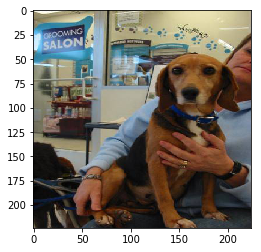

In [13]:
plt.imshow(np.array(train_data[8]).astype(np.uint8).transpose(1,2,0),interpolation='none') #(height,width,dim)
print(train_labels[8])
!pip install bcolz

In [14]:
import bcolz
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, batch_size=4, class_mode='categorical',
                target_size=(224,224)):
    return gen.flow_from_directory(dirname, target_size=target_size,
            class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)
def get_data(path, target_size=(224,224)):
    batches = get_batches(path, shuffle=False, batch_size=1, class_mode=None, target_size=target_size)
    return np.concatenate([batches.next() for i in range(batches.nb_sample)])


In [15]:
model_path ='.' + 'models/'
val_data = get_data(path+'valid')
trn_data = get_data(path+'train')
save_array(model_path+'train_data.bc', trn_data)
save_array(model_path+'valid_data.bc', val_data)

Found 8 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [16]:
trn_data = load_array(model_path+'train_data.bc')
val_data = load_array(model_path+'valid_data.bc')

In [17]:
def onehot(x): return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

trn_labels=train_imgs.classes
val_labels=val_imgs.classes
val_labels

array([0, 0, 0, 0, 1, 1, 1, 1], dtype=int32)

In [18]:
trn_features = model.predict(trn_data, batch_size=4)
val_features = model.predict(val_data, batch_size=4)


In [19]:
# 1000 inputs, since that's the saved features, and 2 outputs, for dog and cat
lm = Sequential([ Dense(2, activation='softmax', input_shape=(1000,)) ])
lm.compile(optimizer=RMSprop(lr=0.1), loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
lm.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_4 (Dense)                  (None, 2)             2002        dense_input_1[0][0]              
Total params: 2,002
Trainable params: 2,002
Non-trainable params: 0
____________________________________________________________________________________________________


In [21]:
preds = lm.predict_classes(val_features, batch_size=4)
# ...and the probabilities of being a cat
probs = lm.predict_proba(val_features, batch_size=4)[:,0]
probs[:8]

4/8 [==============>...............] - ETA: 0s

array([ 0.501 ,  0.4955,  0.5   ,  0.478 ,  0.503 ,  0.4941,  0.4928,  0.4944], dtype=float32)

In [22]:
preds[:8]

array([0, 1, 1, 1, 0, 1, 1, 1])

In [23]:
filenames = val_imgs.filenames
val_labels

array([0, 0, 0, 0, 1, 1, 1, 1], dtype=int32)

In [24]:
#Most confident images
n_view=5
correct=np.where(preds==val_labels)
idx = permutation(correct)[:n_view][0]
imgs=[val_data[i] for i in idx]
labels=[val_labels[i] for i in idx]
predicted=[preds[i] for i in idx]


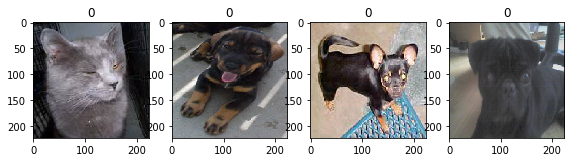

In [25]:
def plotStuff(imgs,labels,predicted):
    figsize=(12,6)
    fig = plt.figure(figsize=figsize)

    for j,i in enumerate(imgs):
            ax = fig.add_subplot(1, n_view+1, j+1)
            vals=str(labels[j])+', '+str(np.round(predicted[j],2))
            ax.set_title(vals)
            plt.imshow(plotThis(i),interpolation='none')
def plotThis(da):
    
    return (np.array(da).astype(np.uint8).transpose(1,2,0)) #(height,width,dim)
    
plotStuff(imgs[:4],labels,predicted)

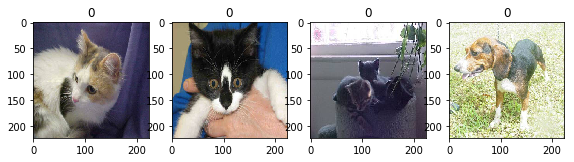

In [26]:
incorrect=np.where(preds!=val_labels)
idx = permutation(incorrect)[:n_view][0]
imgs=[val_data[i] for i in idx]
labels=[val_labels[i] for i in idx]
predicted=[preds[i] for i in idx]

plotStuff(imgs[:4],labels[:4],predicted[:4])

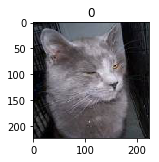

In [27]:
most_confident_cats=np.where((preds==0)&(preds==val_labels))
idx = permutation(most_confident_cats)[:n_view][0]
imgs=[val_data[i] for i in idx]
labels=[val_labels[i] for i in idx]
predicted=[preds[i] for i in idx]

plotStuff(imgs[:4],labels[:4],predicted[:4])

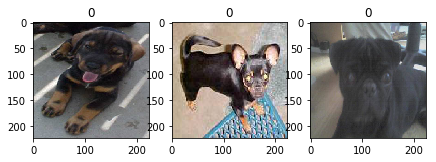

In [28]:
most_confident_dogs=np.where((preds==1)&(preds==val_labels))
idx = permutation(most_confident_dogs)[:n_view][0]
imgs=[val_data[i] for i in idx]
labels=[val_labels[i] for i in idx]
predicted=[preds[i] for i in idx]

plotStuff(imgs[:4],labels[:4],predicted[:4])

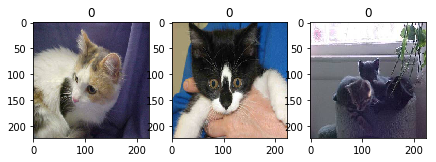

In [29]:
most_confident_dogs_incorrect=np.where((preds==1)&(preds!=val_labels))
idx = permutation(most_confident_dogs_incorrect)[:n_view][0]
imgs=[val_data[i] for i in idx]
labels=[val_labels[i] for i in idx]
predicted=[preds[i] for i in idx]

plotStuff(imgs[:4],labels[:4],predicted[:4])

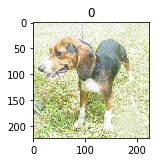

In [30]:
most_confident_cats_incorrect=np.where((preds==0)&(preds!=val_labels))
idx = permutation(most_confident_cats_incorrect)[:n_view][0]
imgs=[val_data[i] for i in idx]
labels=[val_labels[i] for i in idx]
predicted=[preds[i] for i in idx]

plotStuff(imgs[:4],labels[:4],predicted[:4])

In [31]:
model = VGG_16()
fpath = get_file('vgg16.h5', FILES_PATH+'vgg16.h5', cache_subdir='models')
model.load_weights(fpath)
model.pop()
for layer in model.layers: layer.trainable=False
model.add(Dense(2, activation='softmax'))
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [36]:
from keras.optimizers import SGD, RMSprop, Adam

model.compile(keras.optimizers.Adam(lr=0.0001), 'categorical_crossentropy', metrics=['accuracy'])

In [39]:
# run it!
path="/data/"


train_gen=image.ImageDataGenerator()
train_imgs=train_gen.flow_from_directory(path+'train', target_size=(224,224), 
                class_mode='categorical', shuffle=True, batch_size=15)


Found 16 images belonging to 2 classes.


In [40]:
val_imgs=train_gen.flow_from_directory(path+'valid', target_size=(224,224), 
                class_mode='categorical', shuffle=True, batch_size=15)


Found 8 images belonging to 2 classes.


In [41]:
model.fit_generator(train_imgs,
                   samples_per_epoch = train_imgs.N ,
                    nb_epoch=1,
                   validation_data = val_imgs, 
                  nb_val_samples = val_imgs.N )



Epoch 1/1
16/16 [==============================] - 70s - loss: 1.2881 - acc: 0.5625 - val_loss: 0.9039 - val_acc: 0.6250


In [44]:
model.save_weights(model_path+'finetune1.h5')


In [46]:
#Notice we are passing in the validation dataset to the fit() method
#For each epoch we test our model against the validation set
latest_weights_filename = None
no_of_epochs=2
for epoch in range(no_of_epochs):
    print ("Running epoch: %d" % epoch)
    model.fit_generator(train_imgs,
                   samples_per_epoch = train_imgs.nb_sample ,
                    nb_epoch=1,
                   validation_data = val_imgs, 
                  nb_val_samples = val_imgs.nb_sample )
    latest_weights_filename = 'ft%d.h5' % epoch
    model.save_weights('./'+latest_weights_filename)
print ("Completed %s fit operations" % no_of_epochs)

Running epoch: 0
Epoch 1/1
16/16 [==============================] - 70s - loss: 0.7005 - acc: 0.6250 - val_loss: 0.5989 - val_acc: 0.8750
Running epoch: 1
Epoch 1/1
16/16 [==============================] - 68s - loss: 0.6399 - acc: 0.8750 - val_loss: 0.5779 - val_acc: 0.8750
Running epoch: 2
Epoch 1/1
16/16 [==============================] - 68s - loss: 0.0947 - acc: 1.0000 - val_loss: 0.6656 - val_acc: 0.8750
Completed 3 fit operations


In [ ]:
%mkdir test
%mkdir ./test/unknown
%cp /data/test1/* ./test/unknown/

In [47]:
test_imgs=train_gen.flow_from_directory('./test', target_size=(224,224), 
                class_mode=None, shuffle=False, batch_size=15)
test_imgs

Found 8 images belonging to 2 classes.


In [ ]:
preds=model.predict_generator(test_imgs, test_imgs.nb_sample)



In [50]:
filenames = test_imgs.filenames
print(preds[:4],filenames[:4])
save_array('./' + 'test_preds.dat', preds)
save_array('./' + 'filenames.dat', filenames)

['cats/cat.10435.jpg', 'cats/cat.4319.jpg', 'cats/cat.4785.jpg', 'cats/cat.5202.jpg', 'dogs/dog.10459.jpg', 'dogs/dog.11314.jpg', 'dogs/dog.4090.jpg', 'dogs/dog.5697.jpg']


In [51]:
model.load_weights(model_path+latest_weights_filename)

In [52]:
val_batch=train_gen.flow_from_directory(path+'valid', target_size=(224,224), 
                 shuffle=False, batch_size=15)

val_preds=model.predict_generator(val_batch, test_imgs.nb_sample)


Found 8 images belonging to 2 classes.


array([[  9.9969e-01,   3.1003e-04],
       [  9.2053e-01,   7.9474e-02]], dtype=float32)

In [54]:
val_preds[:,0]
val_imgs.classes

array([0, 0, 0, 0, 1, 1, 1, 1], dtype=int32)

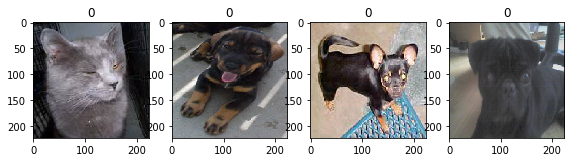

In [58]:
our_labels = np.round(1-val_preds[:,0])
val_labels=val_imgs.classes
n_view=4
correct=np.where(our_labels==val_labels)
%matplotlib inline
def showStuff(correct):
    idx = permutation(correct)[:n_view][0]
    imgs=[val_data[i] for i in idx]
    labels=[val_labels[i] for i in idx]
    predicted=[our_labels[i] for i in idx]

    plotStuff(imgs[:4],labels[:4],predicted[:4])    
    

showStuff(correct)

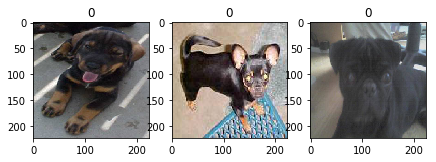

In [60]:
most_confident_dogs=np.where((our_labels==val_labels)&(val_labels==1))

showStuff(most_confident_dogs)

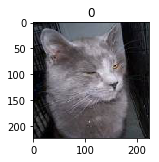

In [61]:
most_confident_cats=np.where((our_labels==val_labels)&(val_labels==0))

showStuff(most_confident_cats)

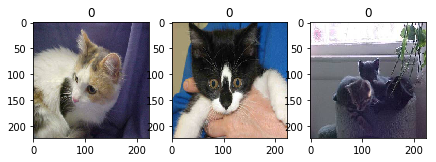

In [62]:
most_inconfident_cats=np.where((our_labels!=val_labels)&(val_labels==0))
showStuff(most_inconfident_cats)

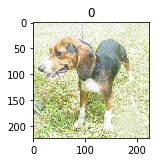

In [63]:
most_inconfident_dogs=np.where((our_labels!=val_labels)&(val_labels==1))
showStuff(most_inconfident_dogs)

In [65]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(val_labels, our_labels)
cm

array([[4, 0],
       [1, 3]])

In [ ]:
preds = load_array('./' + 'test_preds.dat')
filenames = load_array('./' + 'filenames.dat')
isdog = preds[:,1]
print ("Raw Predictions: " + str(isdog[:5]))
print ("Mid Predictions: " + str(isdog[(isdog < .6) & (isdog > .4)]))
print ("Edge Predictions: " + str(isdog[(isdog == 1) | (isdog == 0)]))

In [ ]:
isdog = isdog.clip(min=0.05, max=0.95)

ids = np.array([int(f[8:f.find('.')]) for f in filenames])
subm = np.stack([ids,isdog], axis=1)
subm[:5]


In [ ]:
submission_file_name = 'submission1.csv'
np.savetxt(submission_file_name, subm, fmt='%d,%.5f', header='id,label', comments='')
from IPython.display import FileLink
FileLink('./'+submission_file_name)